In [1]:
import numpy
from sklearn.decomposition import PCA
import imaginet.data_provider as dp
import pylab

In [2]:
import theano
import theano.tensor as T

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: Tesla K20m


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [4]:
prov = dp.getDataProvider('coco', root='/home/gchrupala/repos/reimaginet')
sent_val = [s['raw'] for s in prov.iterSentences(split='val') ]

In [5]:
from imaginet.driver import *

In [6]:
modeldir = "/home/gchrupala/repos/reimaginet/run-104-extratrain/"
M = load(modeldir, model_name='model.5.pkl.gz')

/usr/local/lib/python2.7/dist-packages/Theano-0.6.0-py2.7.egg/theano/tensor/subtensor.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  start in [None, 0] or
/usr/local/lib/python2.7/dist-packages/Theano-0.6.0-py2.7.egg/theano/tensor/subtensor.py:114: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  stop in [None, length, maxsize] or
/usr/local/lib/python2.7/dist-packages/Theano-0.6.0-py2.7.egg/theano/tensor/opt.py:2165: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if (replace_x == replace_y and
/usr/local/lib/python2.7/dist-packages/Theano-0.6.0-py2.7.egg/theano/scan_module/scan_perform_ext.py:85: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


In [7]:
sents = [ s.split() for s in ['two giraffes in a grassy area', 'some zebras running around',
                              'a woman playing badmington', 'a girl plays frisbee', 
                              'a slice of pizza', 'a bowl of salad',
                              ] ]

In [8]:
from scipy.interpolate import spline, interp1d, UnivariateSpline

class Trailer(object):
    
    def __init__(self, model, algo='pca'):
        self.algo = algo
        self.model = model
        self.network = self.model['model'].network
        self._predict = self._make_predictor()        
    
    def _make_predictor(self):
        input = T.imatrix()
        return theano.function([input], self.network.Visual.Encode(self.network.Embed(input)))

    def embed(self, sents):       
        return self._predict(self.model['batcher'].batch_inp(list(self.model['batcher'].mapper.transform(sents))))
    
    def embed_flatten(self, sents):
        def flatten(x):
            return x.reshape((x.shape[0]*x.shape[1], x.shape[2]))
        def last(x):
            return x.transpose((1,0,2))[-1]
        return numpy.vstack([last(self.embed(batch)) for batch in grouper(sents, 128) ])
    
    def fit(self, data):
        print "Embedding"
        #X = self.embed_flatten(data)
        X = numpy.load(modeldir + 'predict_r.5.npy')
        print "Fitting PCA"
        if self.algo == 'pca':
            self.proj = PCA(n_components=2)
            self.proj.fit(X)
        else:
            raise ValueError("Unknown algo {}".format(self.algo))

    def project(self, sents):
        return self.proj.transform(self.embed(sents))
        
    def trails(self, sents, size=(7,5), loc="best"):
        figure(figsize=size)
        for i in range(len(sents)):
            sent_i = self.embed([sents[i]])[0]
            xy = self.proj.transform(sent_i)
            #xnew = numpy.linspace(xy[0:-1,0].min(), xy[0:-1,0].max(), 50)
            #f = UnivariateSpline(xy[0:-1,0], xy[0:-1,1], k=degree)
            x = xy[0:-1,0] ; y = xy[0:-1,1]
            pylab.plot(x, y, label=' '.join(sents[i]), linewidth=3, alpha=0.3)
            for j in range(0,xy.shape[0]-1):
                pylab.text(xy[j,0], xy[j,1], (sents[i])[j], va='center', ha='center', alpha=0.5)
        legend(loc=loc)

In [9]:
trailer = Trailer(M)

In [10]:
trailer.fit(sent_val)

Embedding
Fitting PCA


(-1.0, 1.5, -0.80000000000000004, 1.0)

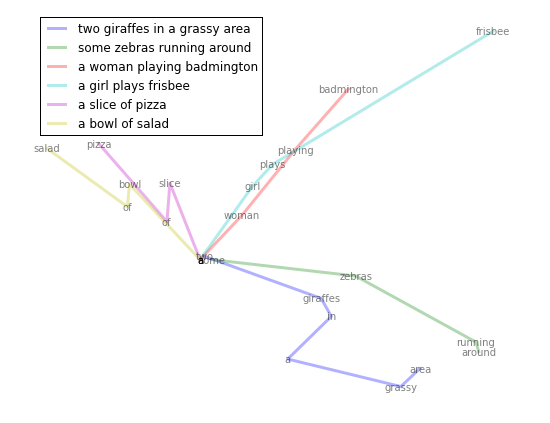

In [12]:
trailer.trails(sents, size=(9,7))
axis('off')


In [14]:
trailer.proj.explained_variance_ratio_

array([ 0.05777309,  0.0475806 ], dtype=float32)

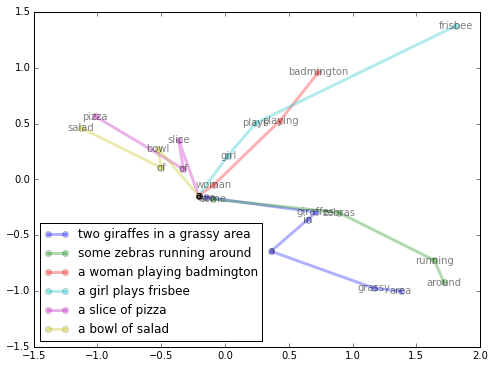

In [129]:
trails(sents, loc='lower left', size=(8,6))

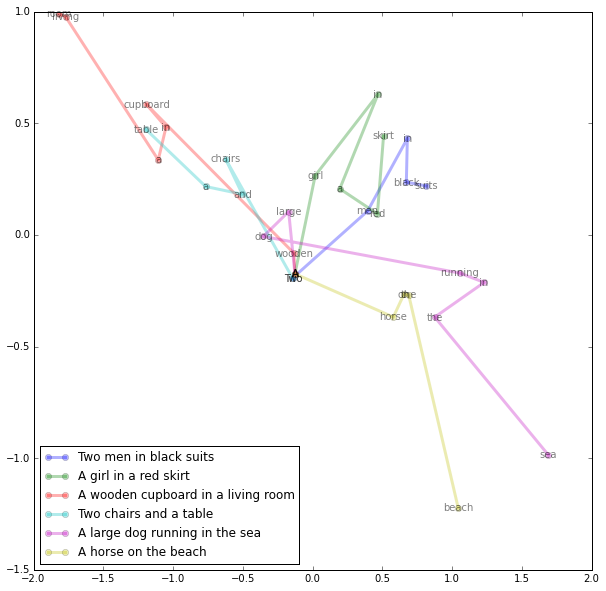

In [31]:
#sample = [ s.split() for s in numpy.random.choice(sent_val,5) ]
sample = [s.split() for s in ['Two men in black suits', 'A girl in a red skirt', 
                              'A wooden cupboard in a living room', 'Two chairs and a table',
                              'A large dog running in the sea', 'A horse on the beach']]
trails(sample, size=(10,10))

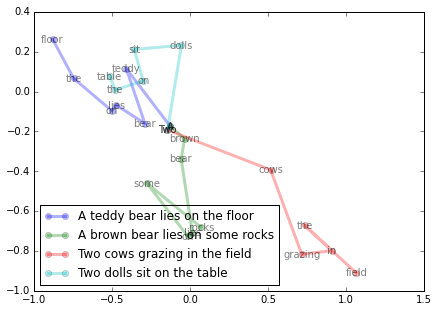

In [32]:
sample = [s.split() for s in ['A teddy bear lies on the floor',
                              'A brown bear lies on some rocks',
                              'Two cows grazing in the field',
                              'Two dolls sit on the table']]
trails(sample)

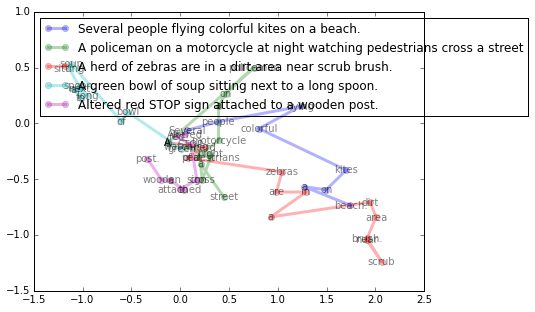

In [73]:
sample = [s.split() for s in numpy.random.choice(sent_val,5) ]
trails(sample, loc='upper left')

In [54]:
pca.transform(embed([['A']])[0])

array([[-0.1274669 , -0.17388569],
       [-0.0637838 , -0.05925323]], dtype=float32)

In [55]:
pca.transform(embed([['Two']])[0])

array([[-0.14454138, -0.19320805],
       [-0.03971236, -0.08221456]], dtype=float32)

In [57]:
pca.transform(embed([['tennis']])[0])

array([[ 1.68633676,  1.60497022],
       [ 1.51917803,  1.72081327]], dtype=float32)

In [59]:
pca.transform(embed([['snow']])[0])

array([[ 0.39308494, -1.0628978 ],
       [ 0.44122541, -0.83004189]], dtype=float32)

In [75]:
pca.transform(embed([['traffic','lights','on','a','busy','street']])[0])

array([[ 0.02473632, -0.33651283],
       [ 0.04853931, -0.61693305],
       [-0.07804474, -0.66023266],
       [-0.16682586, -0.64426839],
       [-0.16229576, -0.66460735],
       [ 0.1733027 , -1.16229892],
       [ 0.12217302, -0.96258414]], dtype=float32)

In [90]:
sample = [s.split() for s in ['Traffic lights on a busy street',
                              'Two giraffes graze on the savannah',
                              'Snowboarders doing tricks',
                              'A woman holds a handbag',
                              'Two men run in the park'
                              ]]

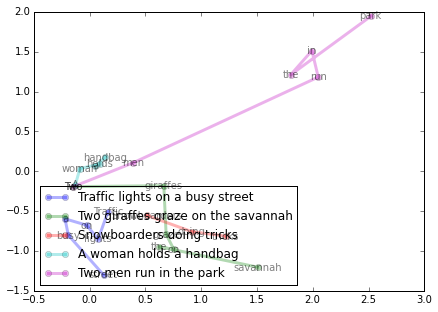

In [91]:
trails(sample)